In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from itertools import islice
from scipy.stats import skew, norm, boxcox_normmax
from scipy.special import boxcox1p
from statsmodels.stats.proportion import proportions_ztest
import warnings
warnings.filterwarnings(action='ignore')

In [14]:
#load data from EDA
df = pd.read_csv("../dataOLD/AdSmartABdata.csv")
df_control = pd.read_csv("../dataOLD/control_df.csv")
df_exposed = pd.read_csv("../dataOLD/exposed_df.csv")


# Hypothesis testing - p-value based algorithm 

* *Null hypothesis: the change in the 'smartAD' design which is newly made for the exposed group would result in no change in the conversion rate.*
* *Alternative hypothesis: the change in the advertisement design would have a positive(improvement) or negative(degradation) effect in the conversion rate.*
* *level of significance = 0.05*

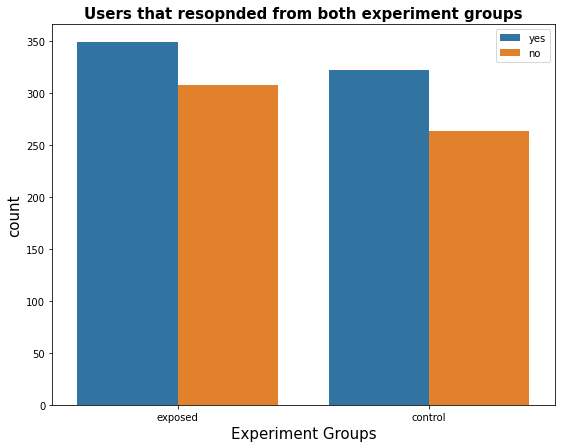

In [15]:
#extract users that didnt respond and users that did, for both experiment groups
drop_df = df.query('yes==0 and no==0')
df = df.drop(drop_df.index)

plt.figure(figsize=(9,7))
ax=sns.countplot(x='experiment', hue='yes', data= df)

ax.set_xlabel('Experiment Groups', fontsize=15)
ax.set_ylabel('count', fontsize=15)
ax.set_title('Users that resopnded from both experiment groups',fontsize=15,fontweight='bold')
plt.legend(['yes','no'])

In [16]:
##copy the dataframe
res = df.copy(deep='true')

In [17]:
# getting users who responded
res = res[res['yes'] == 1].append(res[res['no']==1])
res.head(10)

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
16,008aafdf-deef-4482-8fec-d98e3da054da,exposed,2020-07-04,16,Generic Smartphone,6,Chrome Mobile,1,0
23,00b6fadb-10bd-49e3-a778-290da82f7a8d,control,2020-07-08,4,Samsung SM-A202F,6,Facebook,1,0
45,018af862-486e-4da1-a85b-71872120e57c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,1,0
65,023ec7b5-cb8f-49a5-995f-e0d7c2f702e5,exposed,2020-07-09,13,Samsung SM-G935F,6,Facebook,1,0
89,02efdb70-8596-4f3f-b0b2-b91e194f61f7,exposed,2020-07-05,6,Generic Smartphone,6,Chrome Mobile,1,0
100,0332a7f7-0336-4d48-96ad-75da00d916c0,control,2020-07-04,16,Generic Smartphone,6,Chrome Mobile,1,0
118,03948b84-b5b1-4f26-81fc-e953218aef1a,control,2020-07-09,20,Samsung SM-G930F,6,Facebook,1,0
128,03ee1780-1fa3-4bec-926c-d543a81a6653,exposed,2020-07-04,11,Samsung SM-G981B,6,Chrome Mobile WebView,1,0
144,046644f4-b30c-48f9-b069-f804a97b77d9,exposed,2020-07-05,2,Generic Smartphone,6,Chrome Mobile WebView,1,0
157,04b69bd8-4849-4489-adcf-08b96a265c40,control,2020-07-07,15,Generic Smartphone,6,Chrome Mobile,1,0


In [18]:
#find control and exposed groups
control_df = res[res['experiment'] == 'control']
exposed_df = res[res['experiment'] == 'exposed']

In [19]:
control_df.head(10)

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
23,00b6fadb-10bd-49e3-a778-290da82f7a8d,control,2020-07-08,4,Samsung SM-A202F,6,Facebook,1,0
45,018af862-486e-4da1-a85b-71872120e57c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,1,0
100,0332a7f7-0336-4d48-96ad-75da00d916c0,control,2020-07-04,16,Generic Smartphone,6,Chrome Mobile,1,0
118,03948b84-b5b1-4f26-81fc-e953218aef1a,control,2020-07-09,20,Samsung SM-G930F,6,Facebook,1,0
157,04b69bd8-4849-4489-adcf-08b96a265c40,control,2020-07-07,15,Generic Smartphone,6,Chrome Mobile,1,0
162,04ce7ee1-a4be-4c40-82a9-23f255aa3395,control,2020-07-03,15,ELE-L09,6,Facebook,1,0
201,05ff30c6-4265-4a1d-80de-537563f7470d,control,2020-07-08,18,Generic Smartphone,6,Chrome Mobile,1,0
226,06d7ece2-7d93-43ed-a9d3-e563fb8067e9,control,2020-07-04,19,Generic Smartphone,6,Chrome Mobile,1,0
249,078aa8e5-e424-4d57-b5f2-744b2bd702b5,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,1,0
310,0946d472-f247-4fc8-a5ed-9d76f3c73bfa,control,2020-07-05,10,Samsung SM-G960F,6,Facebook,1,0


In [20]:
exposed_df.head(10)

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
16,008aafdf-deef-4482-8fec-d98e3da054da,exposed,2020-07-04,16,Generic Smartphone,6,Chrome Mobile,1,0
65,023ec7b5-cb8f-49a5-995f-e0d7c2f702e5,exposed,2020-07-09,13,Samsung SM-G935F,6,Facebook,1,0
89,02efdb70-8596-4f3f-b0b2-b91e194f61f7,exposed,2020-07-05,6,Generic Smartphone,6,Chrome Mobile,1,0
128,03ee1780-1fa3-4bec-926c-d543a81a6653,exposed,2020-07-04,11,Samsung SM-G981B,6,Chrome Mobile WebView,1,0
144,046644f4-b30c-48f9-b069-f804a97b77d9,exposed,2020-07-05,2,Generic Smartphone,6,Chrome Mobile WebView,1,0
192,0587d2d4-d47a-4872-ace2-a460eea468f3,exposed,2020-07-09,1,Generic Smartphone,6,Chrome Mobile,1,0
241,07567ef2-71de-41c4-b234-79565a48917e,exposed,2020-07-08,20,Generic Smartphone,6,Chrome Mobile WebView,1,0
244,07659c1c-f6f0-4a6b-8089-97290c26aeb9,exposed,2020-07-08,6,Generic Smartphone,6,Chrome Mobile,1,0
267,08097cbe-a8fe-4336-a917-3da665c5654e,exposed,2020-07-10,15,Generic Smartphone,6,Chrome Mobile,1,0
282,086f31fc-fc25-4c4b-b0ba-ea9ac9502855,exposed,2020-07-08,20,Generic Smartphone,6,Chrome Mobile,1,0


In [21]:
##count yes and no values per day
exposed_dfdate = (exposed_df.groupby('date').agg(yes=('yes','sum'), no=('no','sum')).reset_index())
control_dfdate = (control_df.groupby('date').agg(yes=('yes','sum'), no=('no','sum')).reset_index())

In [22]:
## extract out yes and no for both groups
exposed = exposed_dfdate[['yes','no']]
control = control_dfdate[['yes', 'no']]

In [23]:
# calculate engagements for both groups and append an engagement column
exposed['engagement'] = exposed['yes'] / (exposed['yes'] + exposed['no'])
control['engagement'] = control['yes'] / (control['yes'] + control['no'])

exposed.head()

,yes,no,engagement
0,43,49,0.467391
1,46,45,0.505495
2,35,39,0.472973
3,23,25,0.479167
4,22,24,0.478261


In [24]:
control.head()

,yes,no,engagement
0,104,129,0.446352
1,30,38,0.441176
2,17,26,0.395349
3,12,14,0.461538
4,16,21,0.432432


##  * Now import visualization script and plot histogram for engagement


In [25]:
import sys
sys.path.insert(0, '../scripts')
from VisualisationPlots import VisualiseDf

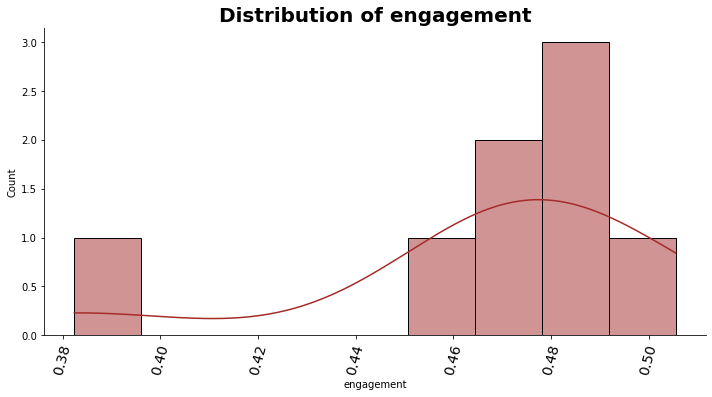

In [26]:
#exposed
VisualiseDf.plot_hist(exposed,'engagement','brown')

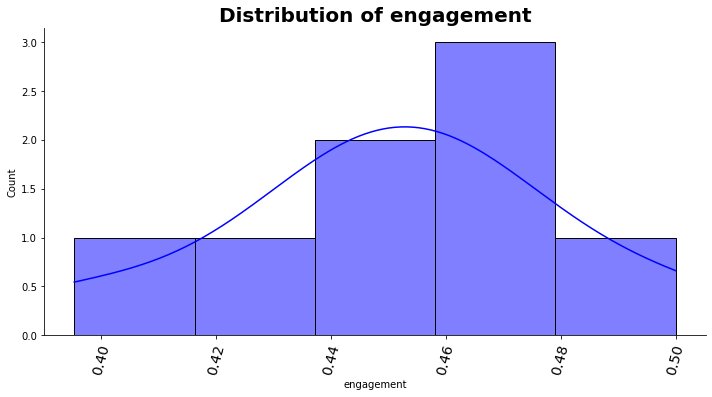

In [27]:
#control
VisualiseDf.plot_hist(control,'engagement','blue')

In [28]:
def find_pr(g1,g2):
    p1 = (g1['yes'].sum()) / float(g1['no'].sum() + g1['yes'].sum())
    p2 = (g2['yes'].sum()) / float(g2['no'].sum() + g2['yes'].sum())
    d = p2-p1
    print(p1,p2,d)
    
find_pr(control,exposed)

0.45051194539249145 0.4687975646879756 0.018285619295484168


In [29]:
#Standard errors
def find_SE(g1, g2):
    
    p_overall = (g1['yes'].sum() + g2['yes'].sum() )/((g1['no'].sum() + g1['yes'].sum())+ (g2['no'].sum() + g2['yes'].sum()))
 
    SE1 = (p_overall * (1 - p_overall))/(g1['no'].sum() + g1['yes'].sum())
    
    SE2 = (p_overall * (1- p_overall))/(g2['no'].sum() + g2['yes'].sum())
    
    SE = np.sqrt(float(SE1) + float(SE2))
    
    print('SE:', SE)
find_SE(control, exposed)

SE: 0.028319932727228023


In [43]:
#t-value
import scipy.stats
def find_T(g1, g2):
    SE = 0.028319932727228023
    d = 0.18285619295484168
    alpha = 0.05
    tStatistic = (d-0) / SE
   
    dof = ((g1['no'].sum() + g1['yes'].sum()) + (g2['no'].sum() + g2['yes'].sum()) - 2.0)
  
    criticalValue = scipy.stats.t.ppf(1.0 - alpha, df = dof)
    
# Confidence Interval
    CI = [d - (criticalValue * SE), d + (criticalValue * SE)]  
    p_val = (1 - scipy.stats.t.cdf(abs(tStatistic), df = dof)) * 2.0
    print(tStatistic,'||', dof,'||', criticalValue,'||', p_val)
find_T(control, exposed)

6.4568018122103705 || 1241.0 || 1.646082405507605 || 1.531008653188337e-10


In [45]:
# conclusion on p value
success = np.array([exposed['yes'].sum(), control['yes'].sum()])
total_response = np.array([exposed['no'].sum() + exposed['yes'].sum(), control['no'].sum() + control['yes'].sum()])
# 
zTest_statistic, zTest_pval = proportions_ztest(success, total_response, value=0, alternative='two-sided')
# 
print(f't-vlaue is {round(zTest_statistic,4)}')
print(f'p-value is {round(zTest_pval,4)}')

t-vlaue is 0.6457
p-value is 0.5185


# --------------------------------------------------------------------------------------------------------------
# To conclude, the p value calculated is much greater than the level of significance, $\alpha$ which is 0.05. This means we cant reject the null hypothesis, and there is no statistically significant difference between the dummy and 'new' adverts. 
# ---------------------------------------------------------------------------------------------------------------